In [1]:
import sys, os
import torch
import numpy as np 
import pandas as pd
sys.path.append("./src")
import torch.optim as opt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable
import model
import loss_function as loss_func
from loss_function import CircleLoss
import utils
import new_models
import anndata as ad
from scipy import sparse
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class dataset(Dataset):

    def __init__(self, counts, anno, time_point, batch_id):

        assert not len(counts) == 0, "Count is empty"
        # normalize the count
        self.libsizes = np.tile(np.sum(counts, axis = 1, keepdims = True), (1, counts.shape[1]))
        # is the tile necessary?
        
        self.counts_norm = counts/self.libsizes * 100
        self.counts_norm = np.log1p(self.counts_norm)
        self.counts = torch.FloatTensor(counts)

        # further standardize the count
        self.counts_stand = torch.FloatTensor(StandardScaler().fit_transform(self.counts_norm))
        self.anno = torch.Tensor(anno)
        self.libsizes = torch.FloatTensor(self.libsizes)
        # make sure the input time point are integer
        self.time_point = torch.LongTensor(time_point)
        self.batch_id = torch.Tensor(batch_id)
    def __len__(self):
        return self.counts.shape[0]
    
    def __getitem__(self, idx):
        # data original data, index the index of cell, label, corresponding labels, batch, corresponding batch number
        if self.anno is not None:
            sample = {"batch_id": self.batch_id[idx], "time_point": self.time_point[idx], "count": self.counts[idx,:], "count_stand": self.counts_stand[idx,:], "index": idx, "anno": self.anno[idx], "libsize": self.libsizes[idx]}
        else:
            sample = {"batch_id": self.batch_id[idx], "time_point": self.time_point[idx],  "count": self.counts[idx,:], "count_stand": self.counts_stand[idx,:], "index": idx, "libsize": self.libsizes[idx]}
        return sample

In [3]:
class SupervisedContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.07):
        """
        Implementation of the loss described in the paper Supervised Contrastive Learning :
        https://arxiv.org/abs/2004.11362
        :param temperature: int
        """
        super(SupervisedContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, projections, targets):
        """
        :param projections: torch.Tensor, shape [batch_size, projection_dim]
        :param targets: torch.Tensor, shape [batch_size]
        :return: torch.Tensor, scalar
        """
        device = torch.device("cuda") if projections.is_cuda else torch.device("cpu")

        dot_product_tempered = torch.mm(projections, projections.T) / self.temperature
        # Minus max for numerical stability with exponential. Same done in cross entropy. Epsilon added to avoid log(0)
        exp_dot_tempered = (
            torch.exp(dot_product_tempered - torch.max(dot_product_tempered, dim=1, keepdim=True)[0]) + 1e-5
        )

        mask_similar_class = (targets.unsqueeze(1).repeat(1, targets.shape[0]) == targets).to(device)
        mask_anchor_out = (1 - torch.eye(exp_dot_tempered.shape[0])).to(device)
        mask_combined = mask_similar_class * mask_anchor_out
        cardinality_per_samples = torch.sum(mask_combined, dim=1)

        log_prob = -torch.log(exp_dot_tempered / (torch.sum(exp_dot_tempered * mask_anchor_out, dim=1, keepdim=True)))
        supervised_contrastive_loss_per_sample = torch.sum(log_prob * mask_combined, dim=1) / cardinality_per_samples
        supervised_contrastive_loss = torch.mean(supervised_contrastive_loss_per_sample)

        return supervised_contrastive_loss

In [4]:
dir = r'./data/covid/processed_covid_sample/'
batch_info = pd.read_csv(dir + 'batch_info.csv', index_col = 0)
merge_meta = pd.read_csv(r'./data/covid/merge_meta.csv', index_col = 0)
pd.set_option('display.max_rows', None)

/nethome/xzhao429/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
merge_meta['majorType'].unique()
type_lst = ['Mono', 'B', 'Macro', 'CD4', 'CD8', 'NK', 'DC', 'Mega', 'Neu',
       'Plasma', 'Epi', 'Mast']
tran_type_lst = le.fit_transform(type_lst)
for i in zip(tran_type_lst, type_lst):
    print(i)

(8, 'Mono')
(0, 'B')
(5, 'Macro')
(1, 'CD4')
(2, 'CD8')
(9, 'NK')
(3, 'DC')
(7, 'Mega')
(10, 'Neu')
(11, 'Plasma')
(4, 'Epi')
(6, 'Mast')


In [6]:
batch_info

,critical,moderate,control
sample0,"(239, 2000)",NaN,NaN
sample1,"(2944, 2000)",NaN,NaN
sample2,"(2101, 2000)",NaN,NaN
sample3,"(637, 2000)",NaN,NaN
sample4,"(155, 2000)",NaN,NaN
sample5,"(5328, 2000)",NaN,NaN
sample6,"(425, 2000)",NaN,NaN
sample7,"(949, 2000)",NaN,NaN
sample8,"(57, 2000)",NaN,NaN
sample9,"(309, 2000)",NaN,NaN


In [7]:
balf_lst = ['S-M074-1',
'S-M075',
'S-S086-1',
'S-M076-1',
'S-S085-1',
'S-S087-1',
'S-S088-1',
'S-S089-1',
'S-S090-1',
'S-S006',
'S-S008',
'S-S009']
sputum_lst = ['S-S010-1',
'S-S011-1',
'S-S012-1',
'S-M002-1',
'S-M003-1',
'S-S010-2',
'S-S005-1',
'S-S001-1',
'S-S007-1',
'S-S007-2',
'S-M003-2',
'S-M003-3',
'S-S005-2',
'S-S011-2',
'S-M002-2',
'S-S012-2',
'S-S002',
'S-S003',
'S-S012-3',
'S-S004-1',
'S-S004-2',
'S-S004-3',
]
print('BALF',set([i.split('-')[-1] for i in merge_meta[(merge_meta['sampleID'].isin(balf_lst))].index.tolist()]))
print('sputum',set([i.split('-')[-1] for i in merge_meta[(merge_meta['sampleID'].isin(sputum_lst))].index.tolist()]))

BALF {'98', '99', '96', '95', '102', '97', '224', '223', '222', '101', '103', '100'}
sputum {'243', '236', '234', '235', '248', '227', '247', '228', '230', '237', '239', '232', '242', '241', '240', '245', '229', '238', '246', '231', '244', '233'}


In [8]:
sv = ['severe/critical', 'mild/moderate']
st = ['progression', 'convalescence']
for i in st:
    for j in sv:
        convalescence = [i.split('-')[-1] for i in merge_meta[(merge_meta['Sample time'] == i) & (merge_meta['severity'] == j)].index.tolist()]
        convalescence = list(set(convalescence))
        convalescence= [int(i) for i in convalescence]
        convalescence.sort()
        print(i, j, np.array(convalescence))
        print('         ')

progression severe/critical [  0   1   2   3   4   5   6   7   8   9  10  18  19  25  26  45  46  49
  69  70  71  72  77  78  79  80  83  84  87  97  99 100 101 102 103 105
 106 109 110 111 112 113 137 139 222 223 224 225 226 227 228 229 232 233
 234 235 236 237 238 239 240 241 242 243 246 247 267 268 269 270 271 272
 273 274 275 276 277 278 279 280 281 282 283]
         
progression mild/moderate [ 11  12  13  17  20  21  22  23  24  92  93  94  95  96  98 107 108 114
 115 116 136 140 142 143 144 148 149 150 230 231 244 245 248]
         
convalescence severe/critical [ 37  38  40  43  44  47  50  51  85  86  88  89 104 119 120 125 126 127
 128 130 138 160 161 162 163 164 165 166 167 168 169 182 183 184 185 186
 187 188 189 191 192 194 200 259 260 261 262 263 264 265 266]
         
convalescence mild/moderate [ 14  15  16  27  28  29  35  36  39  41  42  48  57  58  59  60  63  64
  65  66  73  74  75  76  90  91 121 122 123 124 129 133 134 135 141 145
 146 147 151 152 153 154 155 15

In [9]:
control = [i.split('-')[-1] for i in merge_meta[(merge_meta['Sample time'] == 'control') ].index.tolist()]
control = list(set(control))
control= [int(i) for i in control]
control.sort()
print(np.array(control
              ))

[ 30  31  32  33  34  52  53  54  55  56  61  62  67  68  81  82 117 118
 131 132 219 220 221 249 250 251 252 253]


In [10]:
# import scanpy as sc
# from matplotlib import rcParams

# counts_norms = []
# annos = []
# batch_ids = []
# for batch in range(12):
#     counts_norms.append(datasets[batch].counts_norm)
#     annos.append(datasets[batch].anno)
#     batch_ids.append(datasets[batch].batch_id)
# str_batch_id = [str(i) for i in batch_ids]
# adata = ad.AnnData(np.concatenate(counts_norms, axis = 0))
# obs = {'Cell_Type': np.concatenate(str_annos),
#       'batch_id': np.concatenate(batch_ids)}
# obs = pd.DataFrame(obs, index =  np.concatenate(str_annos))

# adata.obs = obs
# # obs

# sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)
# sc.tl.umap(adata)

# save = r'_pre_integ.png'
# # save = None
# rcParams['figure.figsize'] = 14, 10
# sc.pl.umap(adata, color = ['batch_id', 'Cell_Type'], save = save)

In [20]:
path = r'./data/covid/processed_covid_sample/'
# n_batches = 9
counts_rnas = []
labels = []
timepoints = []
batches = []
datasets = []
str_annos = []
str_batches = []
str_tp = []
batch_dict = {'critical':[[1, 49, 86, 89], 2],
              'moderate':[[63, 76, 96, 153], 1],
              'control':[[61, 62, 67, 81], 0]
}
batch_dict_only_prog = {'critical':[[1, 2, 80], 2],
              'moderate':[[11, 23, 230], 1],
#               'moderate':[[94, 95, 96], 1], 
#                         95 and 96 are BALF
#               'control':[[61, 62, 67, 81], 0]
}

batch_dict_only_conva = {'critical':[[50, 51, 89], 2],
              'moderate':[[75, 76, 151], 1],
#               'control':[[61, 62, 67, 81], 0]
}
batch_dict_conva_ctrl = {'critical':[[50, 51, 89], 2],
              'moderate':[[75, 76, 151], 1],
              'control':[[62, 67, 30], 0]
}
batch_dict_prog_ctrl = {'critical':[[1, 2, 80], 2],
              'moderate':[[11, 23, 230], 1],
              'control':[[62, 67, 30], 0]
}

n = 0
for severity, label in batch_dict_conva_ctrl.items():
    idxes = label[0]
    time_point = label[1]
    for idx in idxes:
        counts_rnas.append(np.array(sparse.load_npz(os.path.join(dir, '{}/mtx_batch_{}_{}.npz'.format(severity,idx,severity))).todense()))
        str_annos.append((pd.read_csv(os.path.join(dir, '{}/meta_batch_{}_{}.csv'.format(severity,idx,severity)))["majorType"]))
        labels.append(le.fit_transform(pd.read_csv(os.path.join(dir, '{}/meta_batch_{}_{}.csv'.format(severity,idx,severity)))["majorType"]))
        str_tp.append(['time point '+str(time_point)+'-'+severity] * counts_rnas[-1].shape[0])
        timepoints.append([time_point] * counts_rnas[-1].shape[0])
        str_batches.append(['batch '+str(n)+'-'+severity]* counts_rnas[-1].shape[0])
        batches.append([n] * counts_rnas[-1].shape[0])
        datasets.append(dataset(counts = counts_rnas[-1],anno = labels[-1], time_point = [time_point] * counts_rnas[-1].shape[0], 
                         batch_id = [n] * counts_rnas[-1].shape[0]))
        print(severity, idx, 'finished')
        n += 1
    
n_batches = len(datasets)

critical 50 finished
critical 51 finished
critical 89 finished
moderate 75 finished
moderate 76 finished
moderate 151 finished
control 62 finished
control 67 finished
control 30 finished


In [21]:
print(set(str_annos[3]))
print(set(np.concatenate(str_annos[:2])))

{'Mono', 'CD8', 'B', 'CD4', 'NK', 'Plasma'}
{'Mono', 'CD8', 'B', 'Neu', 'Mega', 'Macro', 'CD4', 'NK', 'DC', 'Plasma'}


In [22]:
class new_ae(nn.Module):
    """\
    Description:
    --------------
        New model that separate the encoder and control backward gradient. (AUTOENCODER)

    """
    def __init__(self, datasets, Ks = [16, 8], batch_size = 64, interval = 10, lr = 5e-4, lambs = [1,1,1], seed = 0, device = device, contr_loss = None):
        super().__init__()
        # initialize the parameters
        self.datasets = datasets
        self.Ks = {"common_factor": Ks[0], 
                   "time_factor": Ks[1]}

        self.batch_size = batch_size
        self.interval = interval
        self.lr = lr
        self.lambs = lambs
        self.seed = seed 
        self.device = device
        self.contr = contr_loss

        if seed is not None:
            np.random.seed(seed)
            torch.manual_seed(seed)

        # create data loaders
        self.train_loaders = []
        # store the number of cells for each batch
        self.ncells = []
        # store the number of time points
        self.time_points = []
        for batch_id, dataset in enumerate(self.datasets):
            self.train_loaders.append(DataLoader(dataset, batch_size = self.batch_size, shuffle = True))

            self.ncells.append(dataset.counts.shape[0])

            # make sure that the genes are matched
            if batch_id == 0:
                self.ngenes = dataset.counts.shape[1]
            else:
                assert self.ngenes == dataset.counts.shape[1]
            # make sure that each dataset has one unique time point
            time_point = torch.unique(dataset.time_point)
            assert time_point.shape[0] == 1
            self.time_points.append(time_point)

        # create model
        # encoder for common biological factor
        self.Enc_c = model.Encoder(features = [self.ngenes, 256, 64, self.Ks["common_factor"]], dropout_rate = 0, negative_slope = 0.2).to(self.device)
        # encoder for time factor
        self.Enc_t = model.Encoder(features = [self.ngenes, 256, 64, self.Ks["time_factor"]], dropout_rate = 0, negative_slope = 0.2).to(self.device)
        # NOTE: reconstruct the original data, use all latent dimensions as input
        self.Dec = model.Decoder(features = [self.Ks["common_factor"] + self.Ks["time_factor"], 64, 256, self.ngenes], dropout_rate = 0, negative_slope = 0.2).to(self.device)
        # NOTE: classify the time point, out dim = number of unique time points, currently use only time dimensions as input, update the last layer to be linear
        # self.classifier = model.classifier(features = [self.Ks["time_factor"], 4, len(self.time_points)]).to(self.device)
        # use a linear classifier as stated in the paper
        self.classifier = nn.Linear(self.Ks["time_factor"], len(self.time_points)).to(self.device)

        # parameter when training the common biological factor
        self.param_common = [
            {'params': self.Enc_c.parameters()},
            {'params': self.Dec.parameters()}            
        ]

        # parameter when training the time factor
        self.param_time = [
            {'params': self.Enc_t.parameters()},
            {'params': self.classifier.parameters()}            
        ]

        # declare optimizer for time factor and common biological factor separately
        self.opt_common = opt.Adam(self.param_common, lr = self.lr)
        self.opt_time = opt.Adam(self.param_time, lr = self.lr)

    
    def train(self, nepochs = 50):
        lamb_pi = 1e-5
        ce_loss = nn.CrossEntropyLoss(reduction = 'mean')
                
        loss_tests = []
        loss_recon_tests = []
        loss_mmd_tests = []
        loss_class_tests = []

        for epoch in range(nepochs + 1):
            for data_batch in zip(*self.train_loaders):
                loss_recon = 0
                loss_class = 0
                loss_contr = 0
                zs_contr = {}
                zs_contr['time_point'] = []
                zs_contr['x'] = []
                zs_mmd = []
                # 1. train on common factor
                for batch_id, x in enumerate(data_batch):
                    z_c = self.Enc_c(x["count_stand"].to(self.device))
                    # freeze the gradient of Enc_t and classifier
                    # NOTE: use torch no_grad, set requires_grad to False alternatively
                    with torch.no_grad():
                        z_t = self.Enc_t(x["count_stand"].to(self.device))
                    z = torch.concat((z_c, z_t), dim = 1)
                    mu, pi, theta = self.Dec(z)

                    loss_recon += loss_func.ZINB(pi = pi, theta = theta, scale_factor = x["libsize"].to(self.device), ridge_lambda = lamb_pi).loss(y_true = x["count"].to(self.device), y_pred = mu)
                    zs_mmd.append(z_c)
                                
                loss_mmd = loss_func.maximum_mean_discrepancy(xs = zs_mmd, ref_batch = 0)
                loss = self.lambs[0] * loss_recon + self.lambs[1] * loss_mmd
                loss.backward()

                # NOTE: check the gradient of Enc_t and classifier to be None or 0
                with torch.no_grad():
                    for x in self.Enc_t.parameters():
                        assert (x.grad is None) or (torch.sum(x.grad.data.abs()) == 0)
                    for x in self.classifier.parameters():
                        assert (x.grad is None) or (torch.sum(x.grad.data.abs()) == 0)
                        # assert torch.sum(x.grad.data.abs()) < 1e-6
                    for x in self.Enc_c.parameters():
                        assert torch.sum(x.grad.data.abs()) != 0
                    for x in self.Dec.parameters():
                        assert torch.sum(x.grad.data.abs()) != 0
                     

                self.opt_common.step()
                self.opt_common.zero_grad()

                # 2. train on time factor
                n = 0 
                for batch_id, x in enumerate(data_batch):
                    # freeze the gradient of Enc_c
                    with torch.no_grad():
                        z_c = self.Enc_c(x["count_stand"].to(self.device))
                    z_t = self.Enc_t(x["count_stand"].to(self.device))
                    zs_contr['x'].append(z_t)
                    zs_contr['time_point'].append(x["time_point"])
                    t_pred = self.classifier(z_t)

                    loss_class += ce_loss(input = t_pred, target = x["time_point"].to(self.device))
                # TODO: contrastive loss, note that the same data batch have cells from only one cluster, contrastive loss should be added jointly
                loss_contr = self.contr(torch.cat(zs_contr['x']), torch.cat(zs_contr['time_point']))
                loss = self.lambs[2] * loss_class + loss_contr * self.lambs[3]
                loss.backward()

                # NOTE: check the gradient of Enc_c and Dec to be 0 or None
                with torch.no_grad():
                    for x in self.Enc_t.parameters():
                        assert torch.sum(x.grad.data.abs()) != 0
                    for x in self.classifier.parameters():
                        assert torch.sum(x.grad.data.abs()) != 0
                    for x in self.Enc_c.parameters():
                        assert (x.grad is None) or (torch.sum(x.grad.data.abs()) == 0)
                        # assert torch.sum(x.grad.data.abs()) < 1e-6
                    for x in self.Dec.parameters():
                        assert (x.grad is None) or (torch.sum(x.grad.data.abs()) == 0)
                        # assert torch.sum(x.grad.data.abs()) < 1e-6

                self.opt_time.step()
                self.opt_time.zero_grad()
            
            # TEST:
            if epoch % self.interval == 0:
                loss_recon_test = 0
                loss_mmd_test = 0
                loss_class_test = 0
                
                zs_mmd = []
                with torch.no_grad():
                    for dataset in self.datasets:
                        z_c = self.Enc_c(dataset.counts_stand.to(self.device))
                        z_t = self.Enc_t(dataset.counts_stand.to(self.device))
                        z = torch.concat((z_c, z_t), dim = 1)
                        mu, pi, theta = self.Dec(z)
                        t_pred = self.classifier(z_t)
                        zs_mmd.append(z_c)

                        loss_class_test += ce_loss(input = t_pred, target = dataset.time_point.to(self.device))
                        loss_recon_test += loss_func.ZINB(pi = pi, theta = theta, scale_factor = dataset.libsizes.to(self.device), ridge_lambda = lamb_pi).loss(y_true = dataset.counts.to(self.device), y_pred = mu)
                    
                    loss_mmd_test = loss_func.maximum_mean_discrepancy(xs = zs_mmd, ref_batch = 0)
                    loss_test = self.lambs[0] * loss_recon + self.lambs[1] * loss_mmd_test + self.lambs[2] * loss_class_test
                    
                    print('Epoch {}, Validating Loss: {:.4f}'.format(epoch, loss_test.item()))
                    info = [
                        'loss reconstruction: {:.5f}'.format(loss_recon_test.item()),
                        'loss mmd: {:.5f}'.format(loss_mmd_test.item()),
                        'loss classification: {:.5f}'.format(loss_class_test.item())
                    ]
                    for i in info:
                        print("\t", i)              
                    
                    loss_tests.append(loss_test.item())
                    loss_recon_tests.append(loss_recon.item())
                    loss_mmd_tests.append(loss_mmd_test.item())
                    loss_class_tests.append(loss_class_test.item())
    
                    # # update for early stopping 
                    # if loss_test.item() < best_loss:# - 0.01 * abs(best_loss):
                        
                    #     best_loss = loss.item()
                    #     torch.save(self.state_dict(), f'../check_points/model.pt')
                    #     count = 0
                    # else:
                    #     count += 1
                    #     print(count)
                    #     if count % int(nepochs/self.interval) == 0:
                    #         self.opt_time.param_groups[0]['lr'] *= 0.5
                    #         self.opt_common.param_groups[0]['lr'] *= 0.5
                    #         print('Epoch: {}, shrink lr to {:.4f}'.format(epoch + 1, self.opt_time.param_groups[0]['lr']))
                    #         if self.opt_time.param_groups[0]['lr'] < 1e-6:
                    #             break
                    #         else:
                    #             self.load_state_dict(torch.load(f'../check_points/model.pt'))
                    #             count = 0  

        return loss_tests, loss_recon_tests, loss_mmd_tests, loss_class_tests

In [26]:
# model1 = new_models.new_ae(datasets = datasets, Ks = [12, 4], batch_size = 128, interval = 10, lr = 5e-4, lambs = [1, 1e-2, 10], seed = 0, device = device)
m, gamma = 0.3, 0.5
lambs = [1, 0.1, 10, 0.1]
contr_loss = CircleLoss(m = m, gamma = gamma)
Ks = [12, 4]
# contr_loss = SupervisedContrastiveLoss()
model1 = new_ae(datasets = datasets, Ks = Ks, batch_size = 128, interval = 10, 
                lr = 5e-4, lambs = lambs, seed = 0, device = device, contr_loss = contr_loss)
# model1 = new_ae(datasets = datasets, Ks = [12, 4], batch_size = 128, interval = 10, lr = 5e-4, lambs = [1, 1e-3, 10], seed = 0, device = device)

In [27]:
losses, *_ = model1.train(nepochs = 100)

Epoch 0, Validating Loss: 197.4006
	 loss reconstruction: 6.43981
	 loss mmd: 0.09168
	 loss classification: 19.07504
Epoch 10, Validating Loss: 120.1602
	 loss reconstruction: 2.01676
	 loss mmd: 0.07720
	 loss classification: 11.81372
Epoch 20, Validating Loss: 103.6235
	 loss reconstruction: 1.69145
	 loss mmd: 0.08070
	 loss classification: 10.19071
Epoch 30, Validating Loss: 93.6027
	 loss reconstruction: 1.59982
	 loss mmd: 0.08402
	 loss classification: 9.19958
Epoch 40, Validating Loss: 78.7710
	 loss reconstruction: 1.54633
	 loss mmd: 0.08479
	 loss classification: 7.72025
Epoch 50, Validating Loss: 58.8501
	 loss reconstruction: 1.50951
	 loss mmd: 0.08317
	 loss classification: 5.73187
Epoch 60, Validating Loss: 41.3300
	 loss reconstruction: 1.48114
	 loss mmd: 0.07956
	 loss classification: 3.98407
Epoch 70, Validating Loss: 25.5890
	 loss reconstruction: 1.46021
	 loss mmd: 0.07226
	 loss classification: 2.41115
Epoch 80, Validating Loss: 26.6232
	 loss reconstruction: 1

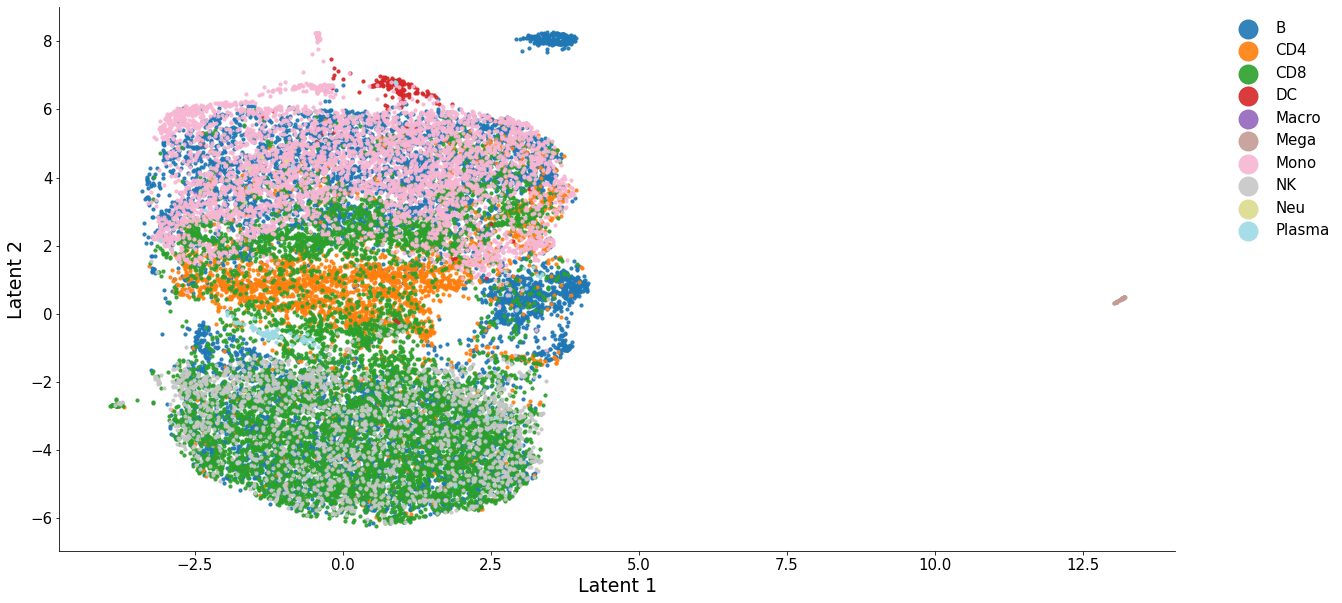

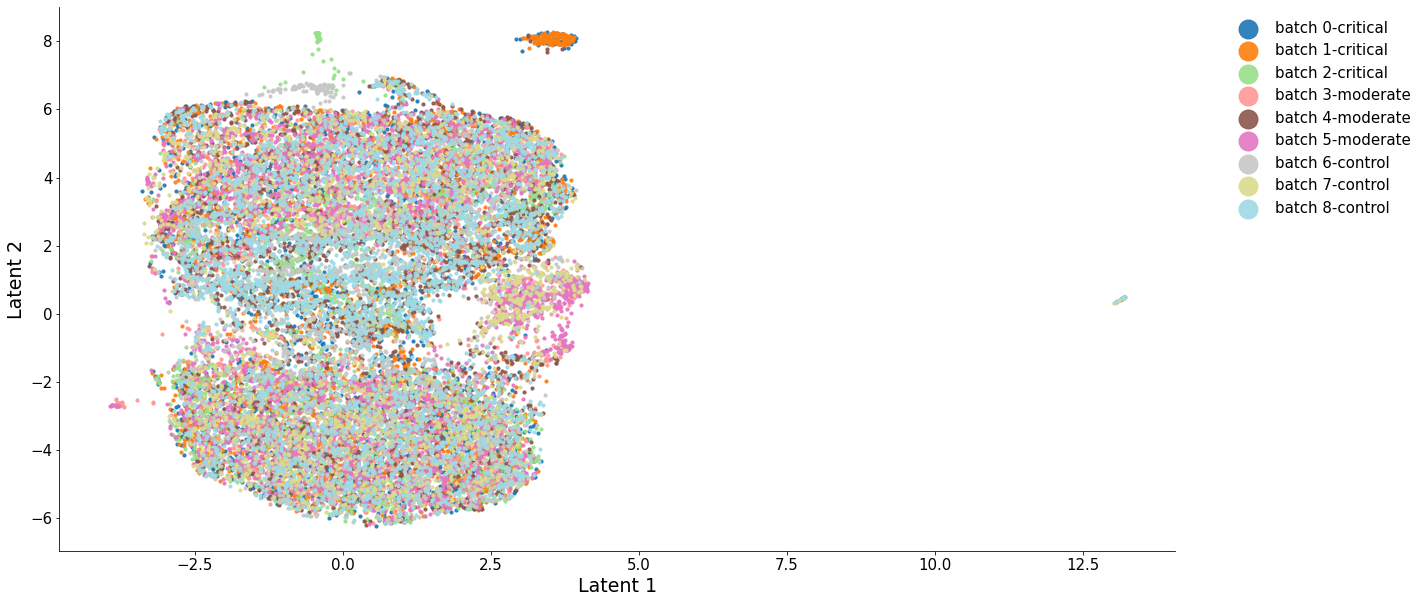

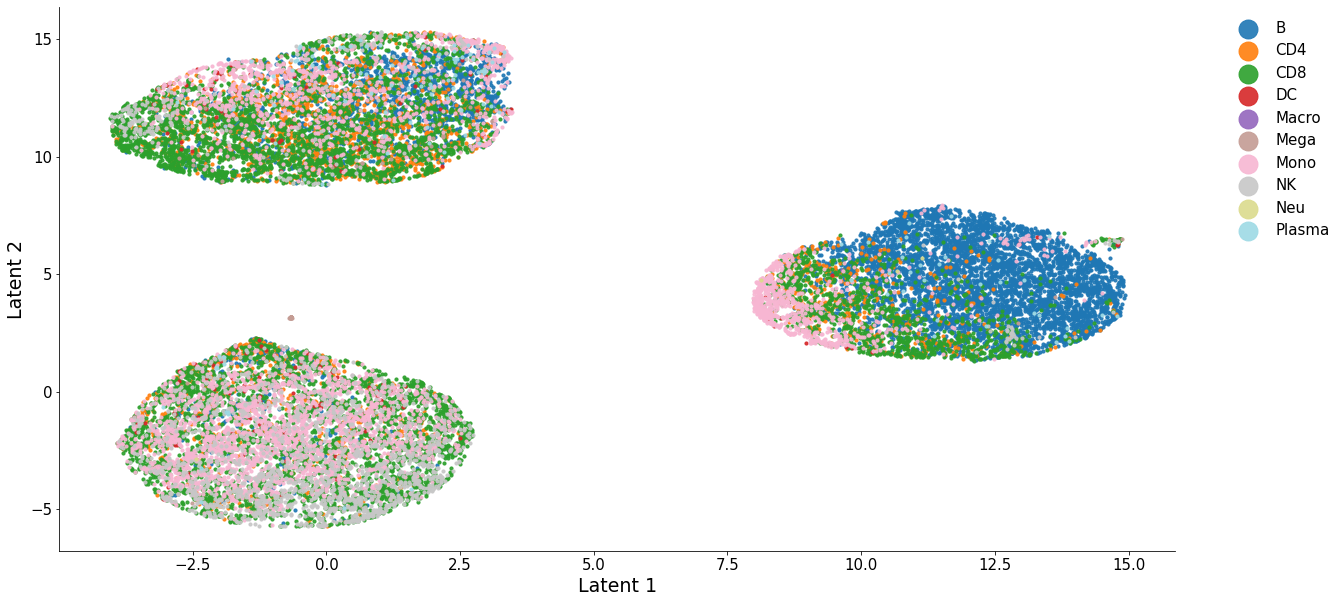

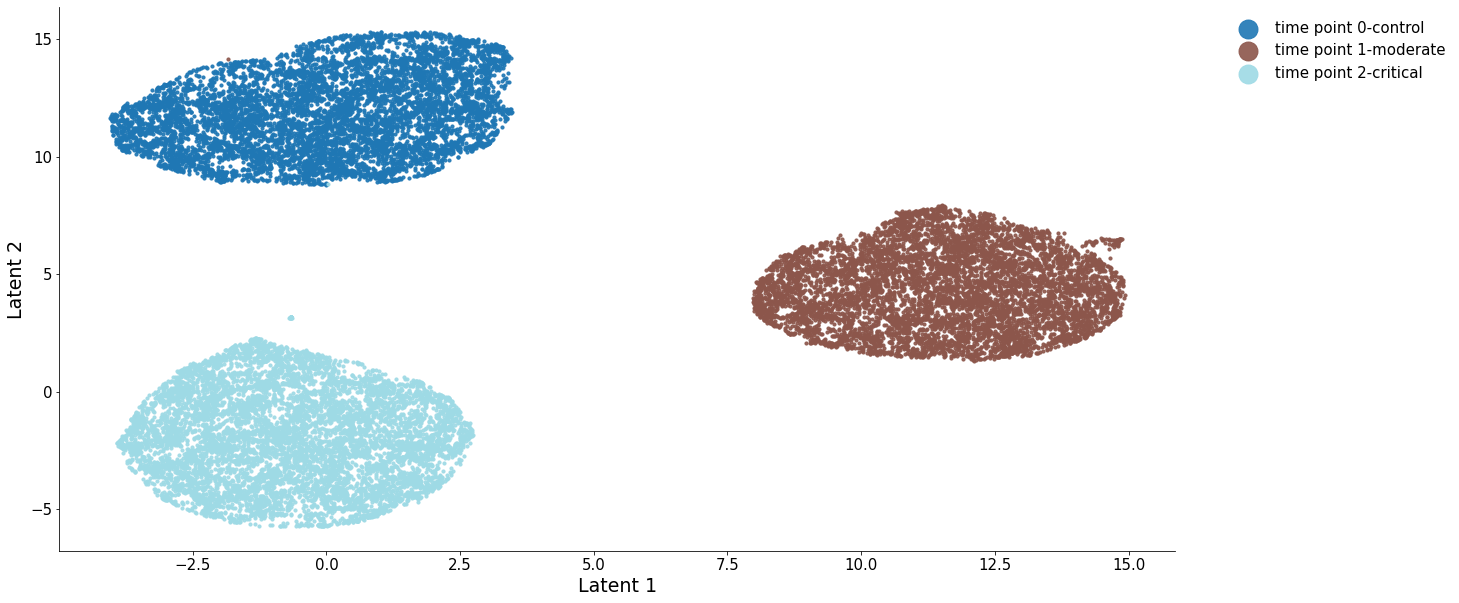

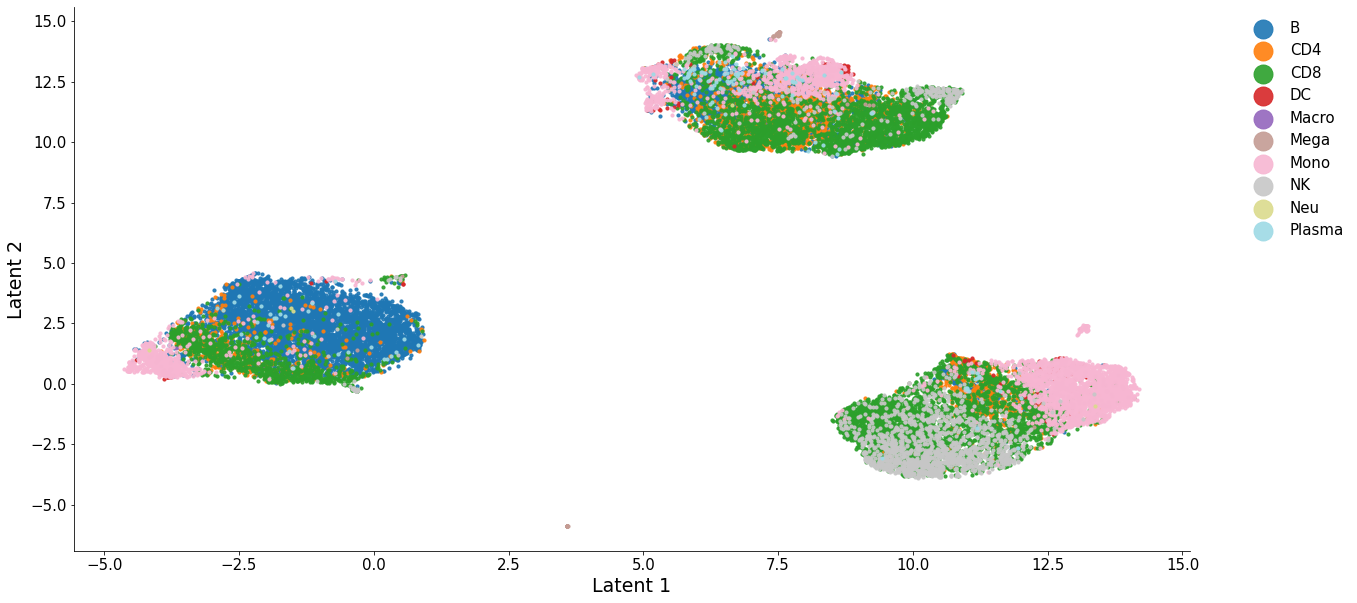

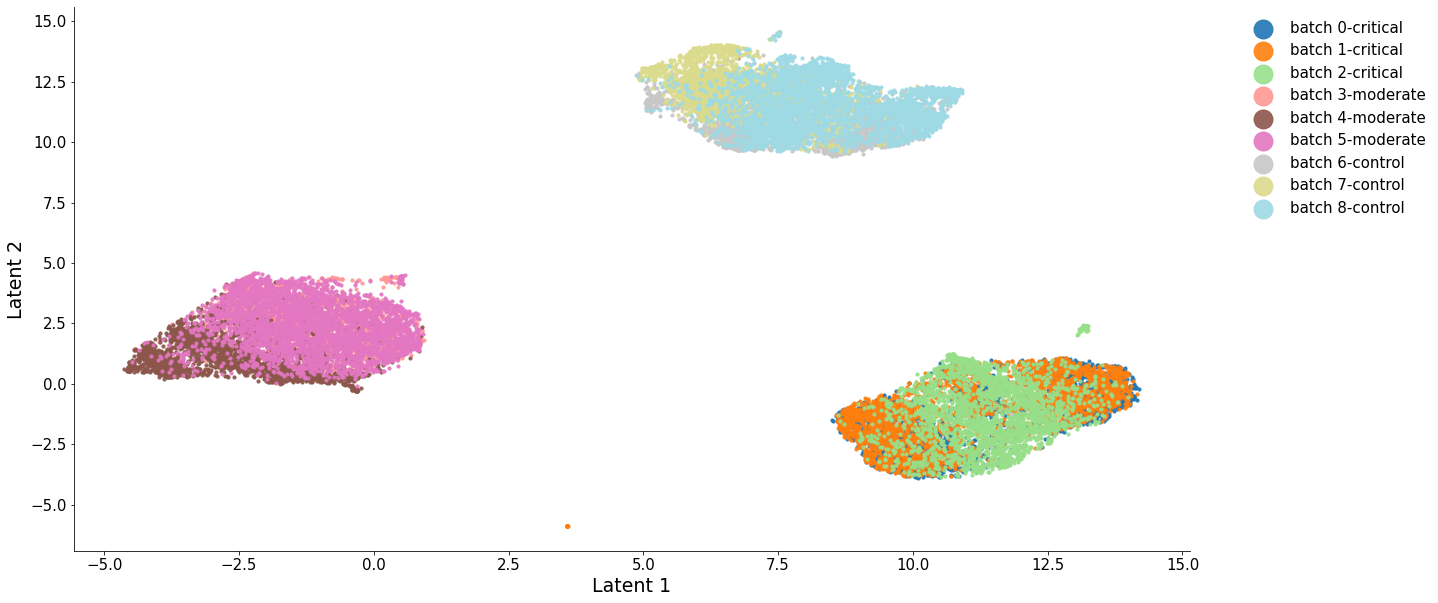

In [32]:
from umap import UMAP

z_cs = []
z_ts = []
zs = []
with torch.no_grad():
    for x in datasets:
        z_c = model1.Enc_c(x.counts_stand.to(model1.device))
        z_t = model1.Enc_t(x.counts_stand.to(model1.device))
        z_cs.append(z_c.cpu().detach().numpy())
        z_ts.append(z_t.cpu().detach().numpy())
        zs.append(torch.cat((z_c, z_t), dim = 1).cpu().detach().numpy())

    # UMAP
    umap_op = UMAP(min_dist = 0.1, random_state = 0)
    z_cs_umap = umap_op.fit_transform(np.concatenate(z_cs, axis = 0))
    z_ts_umap = umap_op.fit_transform(np.concatenate(z_ts, axis = 0))
    zs_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))

    z_ts_umaps = []
    z_cs_umaps = []
    zs_umaps = []
    for batch in range(n_batches):
        if batch == 0:
            start_pointer = 0
            end_pointer = start_pointer + zs[batch].shape[0]
            z_ts_umaps.append(z_ts_umap[start_pointer:end_pointer,:])
            z_cs_umaps.append(z_cs_umap[start_pointer:end_pointer,:])
            zs_umaps.append(zs_umap[start_pointer:end_pointer,:])

        elif batch == (n_batches - 1):
            start_pointer = start_pointer + zs[batch - 1].shape[0]
            z_ts_umaps.append(z_ts_umap[start_pointer:,:])
            z_cs_umaps.append(z_cs_umap[start_pointer:,:])
            zs_umaps.append(zs_umap[start_pointer:,:])

        else:
            start_pointer = start_pointer + zs[batch - 1].shape[0]
            end_pointer = start_pointer + zs[batch].shape[0]
            z_ts_umaps.append(z_ts_umap[start_pointer:end_pointer,:])
            z_cs_umaps.append(z_cs_umap[start_pointer:end_pointer,:])
            zs_umaps.append(zs_umap[start_pointer:end_pointer,:])
#     Ks = [20, 12]
    comment = r'no_BALF_circle_{}_{}_{}_{}_'.format(m, gamma, lambs[-1], Ks)
#     comment = r'SupContr_{}'.format(lambs[-1])
    result_dir = r'./covid_results/new/conva_with_control/'
#     result_dir = None
    utils.plot_latent(zs = z_cs_umaps, annos = str_annos, mode = "joint", save = (result_dir + comment+"common_dims_celltypes.png") if result_dir else None , markerscale = 6)
    utils.plot_latent(zs = z_cs_umaps, annos = str_batches, mode = "joint", save = (result_dir + comment+"common_dims_batches.png".format()) if result_dir else None, markerscale = 6)
    utils.plot_latent(zs = z_ts_umaps, annos = str_annos, mode = "joint", save = (result_dir + comment+"time_dims_celltypes.png".format()) if result_dir else None, markerscale = 6)
    utils.plot_latent(zs = z_ts_umaps, annos = str_tp, mode = "joint", save = (result_dir + comment+"time_dims_timepoint.png".format()) if result_dir else None, markerscale = 6)
    
    utils.plot_latent(zs = zs_umaps, annos = str_annos, mode = "joint", save = (result_dir + comment+"all_dims_celltypes.png") if result_dir else None , markerscale = 6)
    utils.plot_latent(zs = zs_umaps, annos = str_batches, mode = "joint", save = (result_dir + comment+"all_dims_batches.png".format()) if result_dir else None, markerscale = 6)

In [33]:
def plot_latent(zs, annos = None, mode = "joint", save = None, figsize = (20,10), axis_label = "Latent", **kwargs):
    """\
    Description
        Plot latent space
    Parameters
        z1
            the latent space of first data batch, of the shape (n_samples, n_dimensions)
        z2
            the latent space of the second data batch, of the shape (n_samples, n_dimensions)
        anno1
            the cluster annotation of the first data batch, of the  shape (n_samples,)
        anno2
            the cluster annotation of the second data batch, of the  shape (n_samples,)
        mode
            "joint": plot two latent spaces(from two batches) into one figure
            "separate" plot two latent spaces separately
        save
            file name for the figure
        figsize
            figure size
    """
    _kwargs = {
        "s": 10,
        "alpha": 0.9,
        "markerscale": 1,
    }
    _kwargs.update(kwargs)

    fig = plt.figure(figsize = figsize)
    if mode == "modality":
        colormap = plt.cm.get_cmap("Paired", len(zs))
        ax = fig.add_subplot()
        
        for batch in range(len(zs)):
            ax.scatter(zs[batch][:,0], zs[batch][:,1], color = colormap(batch), label = "batch " + str(batch), s = _kwargs["s"], alpha = _kwargs["alpha"])
        ax.legend(loc='upper left', prop={'size': 15}, frameon = False, ncol = 1, bbox_to_anchor=(1.04, 1), markerscale = _kwargs["markerscale"])
        ax.tick_params(axis = "both", which = "major", labelsize = 15)

        ax.set_xlabel(axis_label + " 1", fontsize = 19)
        ax.set_ylabel(axis_label + " 2", fontsize = 19)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)  

    elif mode == "joint":
        ax = fig.add_subplot()
        cluster_types = set()
        for batch in range(len(zs)):
            cluster_types = cluster_types.union(set([x for x in np.unique(annos[batch])]))
        colormap = plt.cm.get_cmap("tab20", len(cluster_types))
        cluster_types = sorted(list(cluster_types))
        for i, cluster_type in enumerate(cluster_types):
            z_clust = []
            for batch in range(len(zs)):
                index = np.where(np.array(annos[batch], dtype = object) == cluster_type)[0]
                z_clust.append(zs[batch][index,:])
            ax.scatter(np.concatenate(z_clust, axis = 0)[:,0], np.concatenate(z_clust, axis = 0)[:,1], color = colormap(i), label = cluster_type, s = _kwargs["s"], alpha = _kwargs["alpha"])
        
        ax.legend(loc='upper left', prop={'size': 15}, frameon = False, ncol = 1, bbox_to_anchor=(1.04, 1), markerscale = _kwargs["markerscale"])
        
        ax.tick_params(axis = "both", which = "major", labelsize = 15)

        ax.set_xlabel(axis_label + " 1", fontsize = 19)
        ax.set_ylabel(axis_label + " 2", fontsize = 19)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)  


    elif mode == "separate":
        axs = fig.subplots(len(zs),1)
        cluster_types = set()
        for batch in range(len(zs)):
            cluster_types = cluster_types.union(set([x for x in np.unique(annos[batch])]))
        cluster_types = sorted(list(cluster_types))
        colormap = plt.cm.get_cmap("tab20", len(cluster_types))


        for batch in range(len(zs)):
            z_clust = []
            for i, cluster_type in enumerate(cluster_types):
                index = np.where(annos[batch] == cluster_type)[0]
                axs[batch].scatter(zs[batch][index,0], zs[batch][index,1], color = colormap(i), label = cluster_type, s = _kwargs["s"], alpha = _kwargs["alpha"])
            
            axs[batch].legend(loc='upper left', prop={'size': 15}, frameon = False, ncol = 1, bbox_to_anchor=(0.94, 1), markerscale = _kwargs["markerscale"])
            axs[batch].set_title("batch " + str(batch + 1), fontsize = 25)

            axs[batch].tick_params(axis = "both", which = "major", labelsize = 15)

            axs[batch].set_xlabel(axis_label + " 1", fontsize = 19)
            axs[batch].set_ylabel(axis_label + " 2", fontsize = 19)
            # axs[batch].set_xlim(np.min(np.concatenate((z1[:,0], z2[:,0]))), np.max(np.concatenate((z1[:,0], z2[:,0]))))
            # axs[batch].set_ylim(np.min(np.concatenate((z1[:,1], z2[:,1]))), np.max(np.concatenate((z1[:,1], z2[:,1]))))
            axs[batch].spines['right'].set_visible(False)
            axs[batch].spines['top'].set_visible(False)  
        
        
    if save:
        fig.savefig(save, bbox_inches = "tight")
plot_latent(zs = zs_umaps, annos = str_annos, mode = "joint", save = (result_dir + comment+"all_dims_celltypes.png") if result_dir else None , markerscale = 6)


# VAE

In [15]:
class new_vae(nn.Module):
    """\
    Description:
    --------------
        New model that separate the encoder and control backward gradient. 

    """
    def __init__(self, datasets, Ks = [16, 8], batch_size = 64, interval = 10, lr = 5e-4, lambs = [1,1,1], seed = 0, device = device):
        super().__init__()
        # initialize the parameters
        self.datasets = datasets
        self.Ks = {"common_factor": Ks[0], 
                   "time_factor": Ks[1]}

        self.batch_size = batch_size
        self.interval = interval
        self.lr = lr
        self.lambs = lambs
        self.seed = seed 
        self.device = device

        if seed is not None:
            np.random.seed(seed)
            torch.manual_seed(seed)

        # create data loaders
        self.train_loaders = []
        # store the number of cells for each batch
        self.ncells = []
        # store the number of time points
        self.time_points = []
        for batch_id, dataset in enumerate(self.datasets):
            self.train_loaders.append(DataLoader(dataset, batch_size = self.batch_size, shuffle = True))

            self.ncells.append(dataset.counts.shape[0])

            # make sure that the genes are matched
            if batch_id == 0:
                self.ngenes = dataset.counts.shape[1]
            else:
                assert self.ngenes == dataset.counts.shape[1]
            # make sure that each dataset has one unique time point
            time_point = torch.unique(dataset.time_point)
            assert time_point.shape[0] == 1
            self.time_points.append(time_point)

        # create model
        # encoder for common biological factor
        self.Enc_c = model.Encoder_var(features = [self.ngenes, 256, 64, self.Ks["common_factor"]], dropout_rate = 0, negative_slope = 0.2).to(self.device)
        # encoder for time factor
        self.Enc_t = model.Encoder_var(features = [self.ngenes, 256, 64, self.Ks["time_factor"]], dropout_rate = 0, negative_slope = 0.2).to(self.device)
        # NOTE: reconstruct the original data, use all latent dimensions as input
        self.Dec = model.Decoder(features = [self.Ks["common_factor"] + self.Ks["time_factor"], 64, 256, self.ngenes], dropout_rate = 0, negative_slope = 0.2).to(self.device)
        # NOTE: classify the time point, out dim = number of unique time points, currently use only time dimensions as input, update the last layer to be linear
        # self.classifier = model.classifier(features = [self.Ks["time_factor"], 4, len(self.time_points)]).to(self.device)
        # use a linear classifier as stated in the paper
        self.classifier = nn.Linear(self.Ks["time_factor"], len(self.time_points)).to(self.device)
        # parameter when training the common biological factor
        self.param_common = [
            {'params': self.Enc_c.parameters()},
            {'params': self.Dec.parameters()}            
        ]

        # parameter when training the time factor
        self.param_time = [
            {'params': self.Enc_t.parameters()},
            {'params': self.classifier.parameters()}            
        ]

        # declare optimizer for time factor and common biological factor separately
        self.opt_common = opt.Adam(self.param_common, lr = self.lr)
        self.opt_time = opt.Adam(self.param_time, lr = self.lr)



    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()

        eps = torch.FloatTensor(std.size()).normal_().to(self.device)
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
            
    def train(self, nepochs = 50):
        lamb_pi = 1e-5
        # TODO: in the vanilla vae, beta should be 1, in beta-vae, beta >1, the visualization for both cases are not good. Try beta with smaller value
        beta = 1e-3
        ce_loss = nn.CrossEntropyLoss(reduction = 'mean')

        loss_tests = []
        loss_recon_tests = []
        loss_kl_tests = []
        loss_mmd_tests = []
        loss_class_tests = []

        for epoch in range(nepochs + 1):
            for data_batch in zip(*self.train_loaders):
                loss_recon = 0
                loss_kl = 0

                zs_mmd = []
                # 1. train on common factor
                for batch_id, x in enumerate(data_batch):
                    z_mu_c, z_log_var_c = self.Enc_c(x["count_stand"].to(self.device))
                    # freeze the gradient of Enc_t and classifier
                    # NOTE: use torch no_grad, set requires_grad to False alternatively
                    with torch.no_grad():
                        z_mu_t, z_log_var_t = self.Enc_t(x["count_stand"].to(self.device))
                    z_mu = torch.concat((z_mu_c, z_mu_t), dim = 1)
                    z_log_var = torch.concat((z_log_var_c, z_log_var_t), dim = 1)
                    z = self.reparametrize(z_mu, z_log_var)
                    mu, pi, theta = self.Dec(z)

                    loss_recon += loss_func.ZINB(pi = pi, theta = theta, scale_factor = x["libsize"].to(self.device), ridge_lambda = lamb_pi).loss(y_true = x["count"].to(self.device), y_pred = mu)
                    # kl-divergence
                    loss_kl += torch.sum(z_mu.pow(2).add_(z_log_var.exp()).mul_(-1).add_(1).add_(z_log_var)).mul_(-0.5)
                    # TODO: here I use z before sampled, an alternative is to use the after sample z
                    zs_mmd.append(z_mu_c)
                    
                loss_mmd = loss_func.maximum_mean_discrepancy(xs = zs_mmd, ref_batch = 0)
                # beta = 1 for VAE, beta > 1 for beta-vae
                loss = self.lambs[0] * loss_recon + self.lambs[1] * loss_mmd + beta * loss_kl
                loss.backward()

                # NOTE: check the gradient of Enc_t and classifier to be None or 0
                with torch.no_grad():
                    for x in self.Enc_t.parameters():
                        assert (x.grad is None) or (torch.sum(x.grad.data.abs()) == 0)
                    for x in self.classifier.parameters():
                        assert (x.grad is None) or (torch.sum(x.grad.data.abs()) == 0)
                        # assert torch.sum(x.grad.data.abs()) < 1e-6
                    for x in self.Enc_c.parameters():
                        assert torch.sum(x.grad.data.abs()) != 0
                    for x in self.Dec.parameters():
                        assert torch.sum(x.grad.data.abs()) != 0
                     

                self.opt_common.step()
                self.opt_common.zero_grad()

                loss_class = 0
                loss_kl = 0
                # 2. train on time factor
                for batch_id, x in enumerate(data_batch):
                    # freeze the gradient of Enc_c
                    with torch.no_grad():
                        z_mu_c, z_log_var_c = self.Enc_c(x["count_stand"].to(self.device))
                    z_mu_t, z_log_var_t = self.Enc_t(x["count_stand"].to(self.device))

                    # TODO: should we still sample?? Here I sample again, and then we need to calculate kl loss for the samples
                    z_t = self.reparametrize(z_mu_t, z_log_var_t)
                    t_pred = self.classifier(z_t)
                    loss_class += ce_loss(input = t_pred, target = x["time_point"].to(self.device))

                    loss_kl += torch.sum(z_mu_t.pow(2).add_(z_log_var_t.exp()).mul_(-1).add_(1).add_(z_log_var_t)).mul_(-0.5)

                # TODO: contrastive loss, note that the same data batch have cells from only one cluster, contrastive loss should be added jointly
                
                loss = self.lambs[2] * loss_class + beta * loss_kl
                loss.backward()

                # NOTE: check the gradient of Enc_c and Dec to be 0 or None
                with torch.no_grad():
                    for x in self.Enc_t.parameters():
                        assert torch.sum(x.grad.data.abs()) != 0
                    for x in self.classifier.parameters():
                        assert torch.sum(x.grad.data.abs()) != 0
                    for x in self.Enc_c.parameters():
                        assert (x.grad is None) or (torch.sum(x.grad.data.abs()) == 0)
                        # assert torch.sum(x.grad.data.abs()) < 1e-6
                    for x in self.Dec.parameters():
                        assert (x.grad is None) or (torch.sum(x.grad.data.abs()) == 0)
                        # assert torch.sum(x.grad.data.abs()) < 1e-6

                self.opt_time.step()
                self.opt_time.zero_grad()
            
            # TEST:
            if epoch % self.interval == 0:
                loss_recon_test = 0
                loss_class_test = 0
                loss_kl_test = 0
                
                zs_mmd = []
                with torch.no_grad():
                    for dataset in self.datasets:
                        z_mu_c, z_log_var_c = self.Enc_c(dataset.counts_stand.to(self.device))
                        z_mu_t, z_log_var_t = self.Enc_t(dataset.counts_stand.to(self.device))

                        z_mu = torch.concat((z_mu_c, z_mu_t), dim = 1)
                        z_log_var = torch.concat((z_log_var_c, z_log_var_t), dim = 1)
                        z = self.reparametrize(z_mu, z_log_var)
                        mu, pi, theta = self.Dec(z)
                        # z_t
                        t_pred = self.classifier(z[:, -z_mu_t.shape[1]:])
                        # TODO: here I use mu before sample, an alternative is to use z after sample
                        zs_mmd.append(z_mu_c)

                        loss_class_test += ce_loss(input = t_pred, target = dataset.time_point.to(self.device))
                        loss_recon_test += loss_func.ZINB(pi = pi, theta = theta, scale_factor = dataset.libsizes.to(self.device), ridge_lambda = lamb_pi).loss(y_true = dataset.counts.to(self.device), y_pred = mu)
                        loss_kl_test += torch.sum(z_mu.pow(2).add_(z_log_var.exp()).mul_(-1).add_(1).add_(z_log_var)).mul_(-0.5)

                    loss_mmd_test = loss_func.maximum_mean_discrepancy(xs = zs_mmd, ref_batch = 0)
                    loss_test = self.lambs[0] * loss_recon + self.lambs[1] * loss_mmd_test + self.lambs[2] * loss_class_test + beta * loss_kl_test
                    
                    print('Epoch {}, Validating Loss: {:.4f}'.format(epoch, loss_test.item()))
                    info = [
                        'loss reconstruction: {:.5f}'.format(loss_recon_test.item()),
                        'loss kl: {:.5f}'.format(loss_kl_test.item()),
                        'loss mmd: {:.5f}'.format(loss_mmd_test.item()),
                        'loss classification: {:.5f}'.format(loss_class_test.item())
                    ]
                    for i in info:
                        print("\t", i)              
                    
                    loss_tests.append(loss_test.item())
                    loss_recon_tests.append(loss_recon.item())
                    loss_mmd_tests.append(loss_mmd_test.item())
                    loss_class_tests.append(loss_class_test.item())
                    loss_kl_tests.append(loss_kl_test.item())

                    # # update for early stopping 
                    # if loss_test.item() < best_loss:# - 0.01 * abs(best_loss):
                        
                    #     best_loss = loss.item()
                    #     torch.save(self.state_dict(), f'../check_points/model.pt')
                    #     count = 0
                    # else:
                    #     count += 1
                    #     print(count)
                    #     if count % int(nepochs/self.interval) == 0:
                    #         self.opt_time.param_groups[0]['lr'] *= 0.5
                    #         self.opt_common.param_groups[0]['lr'] *= 0.5
                    #         print('Epoch: {}, shrink lr to {:.4f}'.format(epoch + 1, self.opt_time.param_groups[0]['lr']))
                    #         if self.opt_time.param_groups[0]['lr'] < 1e-6:
                    #             break
                    #         else:
                    #             self.load_state_dict(torch.load(f'../check_points/model.pt'))
                    #             count = 0                            

        return loss_tests, loss_recon_tests, loss_kl_tests, loss_mmd_tests, loss_class_tests